# DLC Live PyTorch Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import glob
import os
import time
import zipfile
from pathlib import Path

import cv2
import gdown
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import onnx
import torch
from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel
from dlclive import DLCLive
from dlclive.benchmark_pytorch import analyze_video
from dlclive.live_inference import analyze_live_video
from IPython.display import display
from onnxconverter_common import float16
# from onnxruntime import quantization

Loading DLC 3.0.0rc4...


/home/dikra/miniconda3/envs/dlc3/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Setup

In [2]:

# Define projects directory
project_directory = "/media/dikra/PhD/DATA/DLC24_Data/test_drive_down"

In [57]:
#Demo code for downloading the dataset directly into the project folder - if we want to include this, it should be moved to top of notebook

# Google Drive file ID and destination path
file_id = "16TR_3mBtJMpMrP-xEJucVnDOVgBIYJuD"
destination = os.path.join(project_directory, "downloaded_file.zip")

print(destination)

# Create project directory if it doesn't exist
os.makedirs(project_directory, exist_ok=True)

# Download the file from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

# Unzip the file
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(project_directory)

# Optional: Remove the zip file after extraction
os.remove(destination)

print("Download and extraction completed.")


In [3]:
# Define root directory
root = os.path.join(project_directory, "dlc-live-dummy")

In [4]:
projects = [d for d in next(os.walk(root))[1]]
project_selection = widgets.Dropdown(
    options=projects,
    value=projects[0],
    description="Choose a Project!",
    disabled=False,
)
display(project_selection)

Dropdown(description='Choose a Project!', options=('fly-kevin', 'hand-track', 'miceJun18_dekr_w32', 'miceJun18…

In [5]:
# Get working directory and read model pytorch config file
working_dir = os.path.join(root, project_selection.value)
model_cfg = read_config_as_dict(Path(working_dir) / "pytorch_config.yaml")

In [6]:
snapshots = glob.glob(os.path.normpath(working_dir + "/*.pt*"))
snapshots = [s.split("/")[-1] for s in snapshots]
snapshot_selection = widgets.Dropdown(
    options=snapshots,
    value=snapshots[0],
    description="Choose your snapshot!",
    disabled=False,
)
display(snapshot_selection)

Dropdown(description='Choose your snapshot!', options=('snapshot-100.pt', 'snapshot-detector-250.pt'), value='…

# Model exporting

### PyTorch to ONNX

In [71]:
# Replace with your onnx model name
onnx_model_name = "superbird_ssdlite" 
onnx_model_path = os.path.join(working_dir, str(onnx_model_name + ".onnx"))

In [72]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

snapshot_path = os.path.join(working_dir, snapshot_selection.value)
# Create pretrained DLC3 PoseModel from snapshot  
model = PoseModel.build(model_cfg["model"])
weights = torch.load(snapshot_path, map_location=device)
model.load_state_dict(weights["model"])

# Random dummy input
dummy_input = torch.zeros((1, 3, 658, 302))

# Export PyTorch model to ONNX
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)
#* Note: batch_size, height, and width dimensions are dynamic, 
#* i.e. the onnx model can take different batch sizes, heights and width

### ONNX fp32 to ONNX fp16

In [ ]:
# FP32 to FP16 conversion
onnx_fp16_model_name = onnx_model_name + "_fp16.onnx"
onnx_fp16_model_path = os.path.join(working_dir, onnx_fp16_model_name)

model_fp32 = onnx.load(onnx_model_path)
model_fp16 = float16.convert_float_to_float16(model_fp32)
onnx.save(model_fp16, onnx_fp16_model_path)

# Experiments

##### Experiment setup

In [7]:
# Modeling settings
model_types = ["pytorch", "onnx"]
devices = ["cpu", "cuda", "tensorrt"]

modeltype_selection = widgets.Dropdown(
    options=model_types,
    value=model_types[0],
    description="ModelType",
    disabled=False,
)
device_selection = widgets.Dropdown(
    options=devices,
    value=devices[0],
    description="Device",
    disabled=False,
)
model_precision = widgets.RadioButtons(options=["FP32", "FP16"], description="Precision")
display(modeltype_selection, device_selection, model_precision)

Dropdown(description='ModelType', options=('pytorch', 'onnx'), value='pytorch')

Dropdown(description='Device', options=('cpu', 'cuda', 'tensorrt'), value='cpu')

RadioButtons(description='Precision', options=('FP32', 'FP16'), value='FP32')

In [8]:
display_choice = widgets.RadioButtons(description="Display?", options=[True, False])
display(display_choice)

RadioButtons(description='Display?', options=(True, False), value=True)

In [9]:
# Display settings
#* Replace the following with your display settings
resize_ratio = 0.25
# cropping = [50, 250, 100, 450]
# dynamic_cropping = (True, 0.5, 10)

### 1-Frame inference

In [14]:
test_images = glob.glob(os.path.normpath(working_dir + "/*.png"))
test_images.extend(glob.glob(os.path.normpath(working_dir + "/*.jpg")))
test_images = [t.split("/")[-1] for t in test_images]

test_img_selection = widgets.Dropdown(
    options=test_images,
    value=test_images[0],
    description="Test Image!",
    disabled=False,
)
display(test_img_selection)

Dropdown(description='Test Image!', options=('2ca588d8d899468ab29afab262a670cb_417.jpg', '3db471710139423582cd…

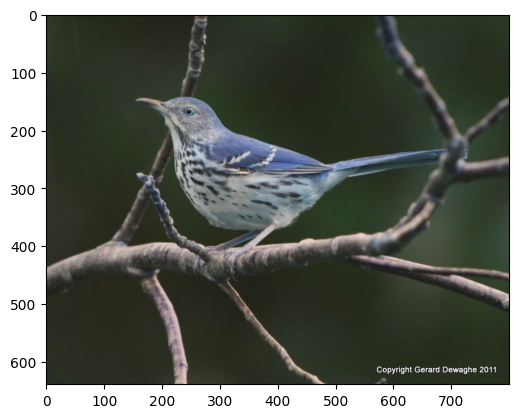

In [15]:
test_image_path = os.path.join(working_dir, test_img_selection.value)
img = cv2.imread(test_image_path)
plt.imshow(img)

In [33]:
def get_model_size(model_path):
    """
    Calculates the size of an ONNX model in bytes.

    Args:
        model_path (str): The path to the ONNX model file.

    Returns:
        int: The size of the model in bytes.
    """
    if ".onnx" in model_path:
        model = onnx.load(model_path)
        size_bytes = len(model.SerializeToString())
    elif ".pt" in model_path:
        model = torch.load(model_path)
        params = list(model.parameters())
        size_bytes = sum([p.numel() * p.element_size() for p in params])

    # Convert to KB, MB, GB, etc.
    if size_bytes < 1024:
        size_str = f"{size_bytes} B"
    elif size_bytes < 1024 * 1024:
        size_str = f"{size_bytes / 1024:.2f} KB"
    elif size_bytes < 1024 * 1024 * 1024:
        size_str = f"{size_bytes / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{size_bytes / (1024 * 1024 * 1024):.2f} GB"

    return size_str

In [36]:

get_model_size(
    working_dir + "/superbird_ssdlite_fp16.onnx"
), get_model_size(
    working_dir + "/superbird_ssdlite.onnx"
)

('45.50 MB', '90.79 MB')

In [16]:
dlc_live = DLCLive(
    path=working_dir,
    model_type=modeltype_selection.value,
    device=device_selection.value,
    display=display_choice.value,
    snapshot=snapshot_selection.value,
    resize=resize_ratio,
    # cropping=cropping,
    # dynamic=dynamic_cropping
    precision=model_precision.value,
)

pose, inf_time = dlc_live.init_inference(frame=img)
print(f"Inference time (ms)", inf_time)
pose

Inference time (ms) 1.7157270908355713


{'poses': tensor([[[[3.4771e+02, 2.2283e+02, 8.2471e-01],
           [1.5893e+02, 1.4392e+02, 8.6377e-01],
           [3.0980e+02, 3.5117e+02, 7.7441e-01],
           [2.4998e+02, 2.9528e+02, 8.1348e-01],
           [2.6623e+02, 1.4498e+02, 7.4707e-01],
           [2.3730e+02, 1.4666e+02, 8.6963e-01],
           [2.5076e+02, 1.6630e+02, 7.6514e-01],
           [3.5164e+02, 3.9204e+02, 2.3486e-01],
           [5.5495e+02, 2.5760e+02, 8.9050e-02],
           [2.7448e+02, 2.6666e+02, 4.1333e-01],
           [3.0284e+02, 1.9597e+02, 7.0605e-01],
           [2.3856e+02, 1.6221e+02, 7.2949e-01],
           [3.5891e+02, 3.9053e+02, 3.3838e-01],
           [5.9094e+02, 2.5106e+02, 1.8799e-01],
           [3.3772e+02, 2.1248e+02, 1.7786e-01],
           [5.9375e+02, 2.5372e+02, 5.9717e-01],
           [2.2638e+02, 2.0418e+02, 8.6133e-01],
           [2.3708e+02, 2.2410e+02, 5.1660e-01],
           [5.9727e+02, 2.6434e+02, 2.2437e-01],
           [5.9475e+02, 2.4911e+02, 2.7319e-01],
           

In [33]:
pose, inf_time = dlc_live.get_pose(frame=img)
print(f"Inference time (ms)", inf_time)
pose

Inference time (ms) 0.07969403266906738


{'poses': tensor([[[[3.1111e+02, 2.0567e+02, 5.9563e-01],
           [1.5795e+02, 1.4836e+02, 5.7864e-01],
           [2.7852e+02, 3.4390e+02, 7.3173e-01],
           [2.2727e+02, 2.5021e+02, 7.7848e-01],
           [2.4916e+02, 1.4925e+02, 7.1121e-01],
           [2.1928e+02, 1.5272e+02, 8.4746e-01],
           [2.4723e+02, 1.6705e+02, 9.4785e-01],
           [3.4636e+02, 3.9325e+02, 4.7768e-01],
           [6.7991e+02, 3.2364e+02, 4.4876e-01],
           [5.6307e+01, 4.2883e+02, 1.7639e-01],
           [2.9118e+02, 1.8471e+02, 6.5662e-01],
           [2.4772e+02, 1.6700e+02, 3.0944e-01],
           [3.2850e+02, 3.9690e+02, 4.6075e-01],
           [6.7293e+02, 3.2181e+02, 4.6248e-01],
           [3.2664e+02, 2.0437e+02, 2.3994e-01],
           [6.5590e+02, 3.7162e+02, 6.3637e-01],
           [2.1900e+02, 1.9598e+02, 7.6429e-01],
           [2.1938e+02, 2.0184e+02, 4.6253e-01],
           [6.5247e+02, 3.7586e+02, 4.3839e-01],
           [6.5878e+02, 3.6948e+02, 4.3056e-01],
           

In [17]:
dlc_live.display.destroy()

### Video inference

In [18]:
test_videos = glob.glob(os.path.normpath(working_dir + "/*.avi"))
test_videos.extend(glob.glob(os.path.normpath(working_dir + "/*.mp4")))
test_videos = [t.split("/")[-1] for t in test_videos]

test_vid_selection = widgets.Dropdown(
    options=test_videos,
    value=test_videos[0],
    description="Test Video!",
    disabled=False,
)
display(test_vid_selection)

Dropdown(description='Test Video!', options=('4782303-hd_1920_1080_25fps.mp4', 'long_bird.mp4', 'pigeon.mp4'),…

In [19]:
def get_video_characteristics(video_path):
    """
    Extracts the FPS, number of frames, length in seconds, and frame size of a video.

    Args:
        video_path (str): The path to the video file.

    Returns:
        tuple: A tuple containing the FPS, number of frames, length in seconds, and frame size.
    """

    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Calculate video length in seconds
    video_length = frame_count / fps

    cap.release()

    return fps, frame_count, video_length, (frame_width, frame_height)

In [20]:
video_path = os.path.join(working_dir, test_vid_selection.value)

fps, frame_count, video_length, frame_size = get_video_characteristics(video_path)

print("FPS:", fps)
print("Number of frames:", frame_count)
print("Video length (seconds):", video_length)
print("Frame size:", frame_size)

FPS: 29.97002997002997
Number of frames: 1077.0
Video length (seconds): 35.935900000000004
Frame size: (1920, 1080)


In [21]:
save_video_choice = widgets.RadioButtons(options=[True, False], description="Save processed video?")
display(save_video_choice)

RadioButtons(description='Save processed video?', options=(True, False), value=True)

In [46]:
# Recap experiment's settings
print(F"Model type: {modeltype_selection.value} \nDevice: {device_selection.value}\nResize ratio: {resize_ratio}\nPrecision: {model_precision.value}")

Model type: onnx 
Device: tensorrt
Resize ratio: 0.25
Precision: FP16


In [47]:
poses, times = analyze_video(
    video_path=video_path,
    model_type=modeltype_selection.value,
    snapshot=snapshot_selection.value,
    device=device_selection.value,
    resize=resize_ratio,
    # cropping=cropping,
    # dynamic=dynamic_cropping
    precision=model_precision.value,
    model_path=working_dir,
    display=display_choice.value,
    save_poses=True,
    save_dir=working_dir + "/out",
    draw_keypoint_names=True,
    save_video=save_video_choice.value
)

{'host_name': 'dikra', 'op_sys': 'Linux-6.8.0-41-generic-x86_64-with-glibc2.39', 'python': 'dlc3', 'device_type': 'GPU', 'device': ['NVIDIA GeForce RTX 3050 6GB Laptop GPU'], 'freeze': ['alabaster==0.7.16', 'albumentations==1.4.3', 'anyio==4.4.0', 'app-model==0.2.7', 'appdirs==1.4.4', 'argon2-cffi==23.1.0', 'argon2-cffi-bindings==21.2.0', 'arrow==1.3.0', 'asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work', 'async-lru==2.0.4', 'attrs==23.2.0', 'Babel==2.15.0', 'beautifulsoup4==4.12.3', 'black==24.4.2', 'bleach==6.1.0', 'blinker==1.8.2', 'blosc2==2.0.0', 'build==1.2.1', 'cachey==0.2.1', 'certifi==2024.7.4', 'cffi==1.17.0', 'charset-normalizer==3.3.2', 'click==8.1.7', 'cloudpickle==3.0.0', 'colorcet==3.1.0', 'coloredlogs==15.0.1', 'comm==0.2.2', 'contourpy==1.2.1', 'cycler==0.12.1', 'Cython==3.0.10', 'dash==2.17.1', 'dash-core-components==2.0.0', 'dash-html-components==2.0.0', 'dash-table==5.0.0', 'dask==2024.7.0', 'dask-expr==1.1.7', 'dask-image==2024.5.3', 'debugpy==1

### Profiling

In [48]:
# Compute mean ± std inference time per frame
print(
    "Mean inference time including 1st inference ",
    np.round(np.mean(times) * 1000, 2),
    "ms ±",
    np.round(np.std(times) * 1000, 2),
)
print(
    "Mean inference time excluding 1st inference ",
    np.round(np.mean(times[1:]) * 1000, 2),
    "ms ±",
    np.round(np.std(times[1:]) * 1000, 2),
)

Mean inference time including 1st inference  49.81 ms ± 1361.7
Mean inference time excluding 1st inference  8.3 ms ± 0.75


In [44]:
def calculate_fps_stats(inference_times):
    """
    Calculates the average FPS rate and its standard deviation from a list of inference times.

    Args:
        inference_times (list): A list of inference times in seconds.

    Returns:
        tuple: A tuple containing the average FPS rate and its standard deviation.
    """

    # Calculate FPS for each frame
    fps_values = [1 / time for time in inference_times]

    # Calculate average FPS
    average_fps = np.mean(fps_values)

    # Calculate standard deviation of FPS
    std_dev_fps = np.std(fps_values)

    return average_fps, std_dev_fps

In [49]:
average_fps, std_dev_fps = calculate_fps_stats(times)

print("Average FPS:", np.round(average_fps, 2))
print("Standard Deviation of FPS:", np.round(std_dev_fps, 2))

Average FPS: 121.38
Standard Deviation of FPS: 11.23


### Live video inference

In [84]:
# Define widgets for experiment_name
experiment_name = widgets.Text(
    value="superbird_live_test",
    description="Experiment Name:",
    style={'description_width': 'initial'}
)

# Display widgets
display(experiment_name)

Text(value='superbird_live_test', description='Experiment Name:', style=DescriptionStyle(description_width='in…

In [85]:
save_video_choice = widgets.RadioButtons(options=[True, False], description="Save processed video?")
display(save_video_choice)

RadioButtons(description='Save processed video?', options=(True, False), value=True)

In [86]:
# Choose which camera to use
# Note: we have only carried out testing using camera 0, i.e. the built-in webcam of a laptop. the max setting is arbitrarily chosen for the moment
camera = widgets.IntSlider(
    value=0,
    min=0,
    max=5,
    step=1,
    description="Camera:",
    style={'description_width': 'initial'}
)

display(camera)

IntSlider(value=0, description='Camera:', max=5, style=SliderStyle(description_width='initial'))

In [97]:
poses, times = analyze_live_video(
    camera=camera.value,
    experiment_name=experiment_name.value,
    model_type=modeltype_selection.value,
    snapshot=snapshot_selection.value,
    device=device_selection.value,
    resize=resize_ratio,
    # cropping=cropping,
    # dynamic=dynamic_cropping
    precision=model_precision.value,
    model_path=working_dir,
    display=display_choice.value,
    save_poses=True,
    save_dir=working_dir + "/out",
    draw_keypoint_names=True,
    save_video=save_video_choice.value
)

{'host_name': 'dikra', 'op_sys': 'Linux-6.8.0-41-generic-x86_64-with-glibc2.39', 'python': 'dlc3', 'device_type': 'GPU', 'device': ['NVIDIA GeForce RTX 3050 6GB Laptop GPU'], 'freeze': ['alabaster==0.7.16', 'albumentations==1.4.3', 'anyio==4.4.0', 'app-model==0.2.7', 'appdirs==1.4.4', 'argon2-cffi==23.1.0', 'argon2-cffi-bindings==21.2.0', 'arrow==1.3.0', 'asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work', 'async-lru==2.0.4', 'attrs==23.2.0', 'Babel==2.15.0', 'beautifulsoup4==4.12.3', 'black==24.4.2', 'bleach==6.1.0', 'blinker==1.8.2', 'blosc2==2.0.0', 'build==1.2.1', 'cachey==0.2.1', 'certifi==2024.7.4', 'cffi==1.17.0', 'charset-normalizer==3.3.2', 'click==8.1.7', 'cloudpickle==3.0.0', 'colorcet==3.1.0', 'coloredlogs==15.0.1', 'comm==0.2.2', 'contourpy==1.2.1', 'cycler==0.12.1', 'Cython==3.0.10', 'dash==2.17.1', 'dash-core-components==2.0.0', 'dash-html-components==2.0.0', 'dash-table==5.0.0', 'dask==2024.7.0', 'dask-expr==1.1.7', 'dask-image==2024.5.3', 'debugpy==1